In [1]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [2]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy
from utils.LB_utils import * 
from utils.load_not_MNIST import notMNIST
import os
import time
import matplotlib.pyplot as plt
from laplace import Laplace

s = 1
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

device:  cuda
cuda status:  True


# Load data

Files already downloaded and verified
Files already downloaded and verified


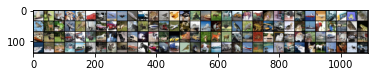

In [4]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


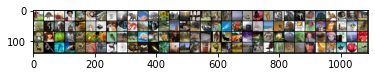

In [5]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Using downloaded and verified file: /home/marius/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


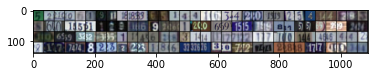

In [6]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [7]:
import torchvision.models as models
SVHN_model = models.resnet18(pretrained=False, num_classes=10).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SVHN_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
best_acc = 0  # best test accuracy

In [9]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [10]:
def test(net, epoch, testloader, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [11]:
def train_all():
    SVHN_path = SVHN_PATH = 'pretrained_weights/SVHN_resnet18_s{}.pth'.format(s)
    SVHN_path_best = SVHN_PATH = 'pretrained_weights/SVHN_resnet18_best_s{}.pth'.format(s)
    lr = 0.1
    epoch = 0
    for e in [10, 10, 5]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(SVHN_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(SVHN_model, epoch, optimizer, SVHN_train_loader, SVHN_path)
            test(SVHN_model, epoch, SVHN_test_loader, SVHN_path_best, save=True)
            epoch += 1
        lr /= 10

In [12]:
#train_all()

In [13]:
##### if you already have a trained model ##############
#SVHN_PATH = 'pretrained_weights/SVHN_resnet18_pretrained.pth'
SVHN_PATH = 'pretrained_weights/SVHN_resnet18_best_s{}.pth'.format(s)
SVHN_model = models.resnet18(pretrained=False, num_classes=10).to(device)
print("loading model from: {}".format(SVHN_PATH))
SVHN_model.load_state_dict(torch.load(SVHN_PATH))#, map_location=torch.device('cpu')))
#test the model
test(SVHN_model, 0, SVHN_test_loader, save=False, path=SVHN_PATH)

loading model from: pretrained_weights/SVHN_resnet18_best_s1.pth
test loss:  1.2069596826622728
current acc: 0.9988859864781807; best acc: 0


In [14]:
targets_CIFAR10 = CIFAR10_testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [15]:
#number of samples to draw from the Gaussian
num_samples = 100

# MAP estimate

In [16]:
SVHN_test_in_MAP = predict_MAP(SVHN_model, SVHN_test_loader, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_MAP = predict_MAP(SVHN_model, CIFAR100_test_loader, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_MAP = predict_MAP(SVHN_model, CIFAR10_test_loader, device=device).cpu().numpy()

In [17]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(SVHN_test_in_MAP, targets_SVHN)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR10_MAP, targets_CIFAR10)

In [18]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'SVHN', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')

[In, MAP, SVHN] Accuracy: 0.999; average entropy: 0.017;     MMC: 0.996; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.613;    MMC: 0.788; AUROC: 0.961; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 0.598;    MMC: 0.793; AUROC: 0.959; Prob @ correct: 0.100


# Diagonal estimate

In [19]:
la_diag = Laplace(SVHN_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='diag',
                     prior_precision=1e+1) # 5e-4 # Choose prior precision such that the MMC for inclass is slightly lower than for MAP
la_diag.fit(SVHN_train_loader)

In [20]:
SVHN_test_in_D = predict_samples(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_D = predict_samples(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_D = predict_samples(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.5558934470000025
time:  1.643242206
time:  0.702650320999993


In [21]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(SVHN_test_in_D, targets_SVHN)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR10_D, targets_CIFAR10)

In [22]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'SVHN', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'SVHN', 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D,  'SVHN', 'CIFAR10', 'Diag')

[In, Diag, SVHN] Accuracy: 0.999; average entropy: 0.077;     MMC: 0.984; Prob @ correct: 0.100
[Out-CIFAR100, Diag, SVHN] Accuracy: 0.010; Average entropy: 0.613;    MMC: 0.687; AUROC: 0.957; Prob @ correct: 0.100
[Out-CIFAR10, Diag, SVHN] Accuracy: 0.089; Average entropy: 0.907;    MMC: 0.689; AUROC: 0.959; Prob @ correct: 0.100


# KFAC estimate

In [23]:
la_kron = Laplace(SVHN_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='kron',
                     prior_precision=5e-1) # 5e-4 # Choose prior precision according to weight decay
la_kron.fit(SVHN_train_loader)

/home/marius/anaconda3/lib/python3.9/site-packages/laplace/utils.py:137: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  L, W = torch.symeig(M, eigenvectors=True)


In [24]:
SVHN_test_in_K = predict_samples(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_K = predict_samples(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_K = predict_samples(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  5.062354335000002
time:  1.874004938000006
time:  0.9513190199999997


In [25]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(SVHN_test_in_K, targets_SVHN)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR100_K, targets_CIFAR100)
acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR10_K, targets_CIFAR10)

In [26]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'SVHN', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'SVHN', 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K,  'SVHN', 'CIFAR10', 'KFAC')

[In, KFAC, SVHN] Accuracy: 0.999; average entropy: 0.074;     MMC: 0.983; Prob @ correct: 0.100
[Out-CIFAR100, KFAC, SVHN] Accuracy: 0.010; Average entropy: 0.613;    MMC: 0.655; AUROC: 0.959; Prob @ correct: 0.100
[Out-CIFAR10, KFAC, SVHN] Accuracy: 0.089; Average entropy: 1.001;    MMC: 0.657; AUROC: 0.960; Prob @ correct: 0.100


# Laplace Bridge estimate

In [27]:
SVHN_test_in_LB_D = predict_LB(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_D = predict_LB(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_D = predict_LB(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

step0, f_mu[0]:  tensor([-0.8389, -0.9765, -1.3394, -0.8472, -2.8224, 10.8968, -0.2168, -1.3096,
        -2.3882, -0.1037], device='cuda:0')
step0, f_var[0]:  tensor([4.7629, 4.2728, 4.5400, 4.1568, 4.8475, 3.5344, 4.4597, 4.8039, 4.7099,
        4.5335], device='cuda:0')
step1, f_mu[0]:  tensor([-0.8446, -0.9817, -1.3449, -0.8522, -2.8283, 10.8925, -0.2222, -1.3154,
        -2.3939, -0.1092], device='cuda:0')
step1, f_var[0]:  tensor([4.2545, 3.8636, 4.0781, 3.7696, 4.3209, 3.2545, 4.0140, 4.2868, 4.2128,
        4.0729], device='cuda:0')
step0, f_mu[0]:  tensor([-1.5177,  1.9676, 10.8685, -2.0002, -0.0142, -1.4307, -3.7323, -1.9849,
        -2.4131,  0.1938], device='cuda:0')
step0, f_var[0]:  tensor([4.3867, 3.3168, 3.0711, 3.9175, 4.0538, 4.3096, 4.5781, 4.2864, 4.2081,
        3.9506], device='cuda:0')
step1, f_mu[0]:  tensor([-1.5108e+00,  1.9728e+00,  1.0873e+01, -1.9940e+00, -7.8026e-03,
        -1.4239e+00, -3.7251e+00, -1.9781e+00, -2.4065e+00,  2.0006e-01],
       device='cu

step0, f_mu[0]:  tensor([-2.8271,  0.5145, -0.4569, -2.8694, 10.8698, -0.5121, -1.3848, -2.3675,
         0.4830, -1.4478], device='cuda:0')
step0, f_var[0]:  tensor([4.6481, 3.5395, 3.9831, 4.2349, 3.3367, 4.2380, 4.3572, 4.7182, 4.0870,
        4.3804], device='cuda:0')
step1, f_mu[0]:  tensor([-2.8273,  0.5144, -0.4570, -2.8695, 10.8697, -0.5123, -1.3850, -2.3677,
         0.4829, -1.4480], device='cuda:0')
step1, f_var[0]:  tensor([4.1278, 3.2378, 3.6010, 3.8030, 3.0686, 3.8054, 3.9000, 4.1821, 3.6847,
        3.9183], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4938,  2.9944, -0.8816, -3.0442,  9.9439, -1.1142, -1.8415, -1.1762,
        -1.0128, -1.3837], device='cuda:0')
step0, f_var[0]:  tensor([4.3592, 3.1051, 3.7102, 3.9628, 3.1138, 3.9796, 4.0956, 4.2461, 3.9312,
        4.1429], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4927,  2.9952, -0.8807, -3.0432,  9.9447, -1.1132, -1.8405, -1.1751,
        -1.0118, -1.3827], device='cuda:0')
step1, f_var[0]:  tensor([3.8675, 2.8556

step0, f_mu[0]:  tensor([ 1.0025, -3.5679, -2.7543, -0.2392, -2.2425, -1.0131,  1.3367, -4.0496,
        10.7050,  0.7904], device='cuda:0')
step0, f_var[0]:  tensor([4.6065, 4.6272, 4.8738, 4.1192, 5.0369, 4.7417, 4.1619, 5.5885, 3.3662,
        4.3544], device='cuda:0')
step1, f_mu[0]:  tensor([ 1.0057, -3.5647, -2.7509, -0.2363, -2.2389, -1.0097,  1.3396, -4.0457,
        10.7073,  0.7935], device='cuda:0')
step1, f_var[0]:  tensor([4.1398, 4.1564, 4.3514, 3.7461, 4.4790, 4.2473, 3.7810, 4.9017, 3.1170,
        3.9375], device='cuda:0')
step0, f_mu[0]:  tensor([-0.5960,  0.7967, -0.9629, 11.8637, -2.1247,  0.6445, -2.5071, -2.3972,
        -1.6823, -3.0566], device='cuda:0')
step0, f_var[0]:  tensor([5.5705, 4.4521, 5.0513, 3.6364, 5.7207, 4.7432, 5.5251, 5.6565, 5.2072,
        5.3741], device='cuda:0')
step1, f_mu[0]:  tensor([-0.5936,  0.7986, -0.9607, 11.8653, -2.1223,  0.6465, -2.5047, -2.3947,
        -1.6801, -3.0543], device='cuda:0')
step1, f_var[0]:  tensor([4.9613, 4.0630

step0, f_mu[0]:  tensor([-2.0913,  1.5064, 10.4690, -1.2914, -0.0855, -1.8635, -3.3274, -0.9927,
        -1.0614, -1.3273], device='cuda:0')
step0, f_var[0]:  tensor([3.8419, 2.8913, 2.6416, 3.3526, 3.4894, 3.7157, 3.8802, 3.5988, 3.5383,
        3.5328], device='cuda:0')
step1, f_mu[0]:  tensor([-2.0840,  1.5118, 10.4740, -1.2850, -0.0789, -1.8565, -3.3201, -0.9859,
        -1.0547, -1.3206], device='cuda:0')
step1, f_var[0]:  tensor([3.4138, 2.6489, 2.4393, 3.0266, 3.1363, 3.3153, 3.4435, 3.2232, 3.1753,
        3.1709], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4660, -2.5995,  2.6570,  1.2457, -1.0848, -1.8301, -4.5703, -3.1384,
        -0.7279, 12.6470], device='cuda:0')
step0, f_var[0]:  tensor([6.9598, 6.3352, 5.9050, 5.8326, 6.9448, 6.8968, 7.6251, 7.6157, 6.5006,
        4.7451], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4801, -2.6123,  2.6450,  1.2338, -1.0989, -1.8442, -4.5858, -3.1538,
        -0.7411, 12.6374], device='cuda:0')
step1, f_var[0]:  tensor([6.2187, 5.7211

step0, f_mu[0]:  tensor([-2.9635,  1.3705, 12.2847, -0.8513, -0.1832, -2.2825, -3.6801, -0.7383,
        -1.4646, -1.5851], device='cuda:0')
step0, f_var[0]:  tensor([5.1366, 3.8371, 3.4651, 4.3623, 4.6436, 4.9149, 5.1615, 4.7302, 4.7114,
        4.7037], device='cuda:0')
step1, f_mu[0]:  tensor([-2.9530,  1.3784, 12.2918, -0.8424, -0.1737, -2.2724, -3.6696, -0.7286,
        -1.4550, -1.5755], device='cuda:0')
step1, f_var[0]:  tensor([4.5589, 3.5147, 3.2022, 3.9456, 4.1714, 4.3859, 4.5781, 4.2403, 4.2253,
        4.2192], device='cuda:0')
step0, f_mu[0]:  tensor([-0.0313, -1.4405, -1.1773,  1.3137, -2.6356, 10.0622, -0.4307, -2.0855,
        -2.8494, -0.6695], device='cuda:0')
step0, f_var[0]:  tensor([4.0879, 3.7568, 3.9833, 3.4069, 4.2779, 3.0196, 3.8730, 4.2897, 4.0858,
        3.9874], device='cuda:0')
step1, f_mu[0]:  tensor([-0.0372, -1.4459, -1.1830,  1.3088, -2.6417, 10.0578, -0.4363, -2.0917,
        -2.8553, -0.6753], device='cuda:0')
step1, f_var[0]:  tensor([3.6569, 3.3927

step0, f_mu[0]:  tensor([-1.7151,  1.2533, 10.1826, -0.8253, -0.6450, -1.4400, -3.1362, -0.6257,
        -1.2830, -1.8257], device='cuda:0')
step0, f_var[0]:  tensor([3.6242, 2.7912, 2.5465, 3.1693, 3.3694, 3.4976, 3.6632, 3.3911, 3.3850,
        3.3917], device='cuda:0')
step1, f_mu[0]:  tensor([-1.7085,  1.2584, 10.1872, -0.8195, -0.6389, -1.4336, -3.1295, -0.6195,
        -1.2768, -1.8195], device='cuda:0')
step1, f_var[0]:  tensor([3.2241, 2.5539, 2.3490, 2.8633, 3.0235, 3.1250, 3.2544, 3.0408, 3.0360,
        3.0413], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4420,  1.6702, -0.2995, 11.3427, -1.3510,  0.1490, -3.8808, -2.3816,
        -1.2165, -1.5886], device='cuda:0')
step0, f_var[0]:  tensor([5.2550, 3.9438, 4.5123, 3.3318, 5.1665, 4.4900, 5.2661, 5.1968, 4.7815,
        4.8554], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4422,  1.6701, -0.2997, 11.3426, -1.3512,  0.1488, -3.8810, -2.3819,
        -1.2167, -1.5888], device='cuda:0')
step1, f_var[0]:  tensor([4.6649, 3.6114

step0, f_mu[0]:  tensor([-0.7905, 10.0113, -1.0711, -2.8428,  0.9033, -0.8772, -0.7761, -2.2311,
        -1.5903, -0.7418], device='cuda:0')
step0, f_var[0]:  tensor([3.4085, 2.0289, 2.9661, 3.1376, 3.0162, 3.3230, 3.2891, 3.2517, 3.2936,
        3.3040], device='cuda:0')
step1, f_mu[0]:  tensor([-0.7898, 10.0117, -1.0705, -2.8422,  0.9039, -0.8765, -0.7754, -2.2305,
        -1.5896, -0.7411], device='cuda:0')
step1, f_var[0]:  tensor([3.0339, 1.8962, 2.6825, 2.8202, 2.7229, 2.9670, 2.9403, 2.9108, 2.9439,
        2.9521], device='cuda:0')
step0, f_mu[0]:  tensor([-0.6569,  1.2198,  9.9026, -1.1278, -0.9545, -0.8753, -3.1619, -0.9778,
        -2.1585, -1.2784], device='cuda:0')
step0, f_var[0]:  tensor([3.4631, 2.7578, 2.5268, 3.1228, 3.3398, 3.3913, 3.5843, 3.3549, 3.3849,
        3.2971], device='cuda:0')
step1, f_mu[0]:  tensor([-0.6495,  1.2257,  9.9080, -1.1211, -0.9474, -0.8681, -3.1543, -0.9707,
        -2.1513, -1.2714], device='cuda:0')
step1, f_var[0]:  tensor([3.0909, 2.5218

step0, f_mu[0]:  tensor([-0.9867, -1.7777,  0.4955,  1.0728, -1.7503, -0.9980, -3.4886, -2.6332,
         0.2049,  9.9461], device='cuda:0')
step0, f_var[0]:  tensor([4.1965, 3.8330, 3.7059, 3.4711, 4.2582, 4.1442, 4.5504, 4.6311, 3.8408,
        2.9400], device='cuda:0')
step1, f_mu[0]:  tensor([-0.9957, -1.7859,  0.4875,  1.0654, -1.7594, -1.0069, -3.4984, -2.6431,
         0.1967,  9.9398], device='cuda:0')
step1, f_var[0]:  tensor([3.7515, 3.4618, 3.3588, 3.1666, 3.8000, 3.7102, 4.0271, 4.0891, 3.4680,
        2.7216], device='cuda:0')
step0, f_mu[0]:  tensor([-1.6279,  9.7671,  1.9333, -1.3337, -1.1105, -1.4015, -2.5331, -0.4246,
        -1.5098, -1.7871], device='cuda:0')
step0, f_var[0]:  tensor([2.8113, 1.4168, 2.0705, 2.3229, 2.4447, 2.6789, 2.8082, 2.3203, 2.6383,
        2.6638], device='cuda:0')
step1, f_mu[0]:  tensor([-1.6247,  9.7688,  1.9357, -1.3310, -1.1077, -1.3984, -2.5298, -0.4219,
        -1.5068, -1.7840], device='cuda:0')
step1, f_var[0]:  tensor([2.4843, 1.3337

step0, f_mu[0]:  tensor([ 9.2255e+00, -1.9696e+00, -1.7950e+00, -6.0680e-01,  1.1848e-01,
        -4.0259e-03, -5.8073e-01, -2.0430e+00, -1.3061e+00, -1.1372e+00],
       device='cuda:0')
step0, f_var[0]:  tensor([2.8417, 3.7447, 4.0418, 3.7104, 4.0384, 3.8364, 3.5380, 4.2889, 3.7271,
        3.7234], device='cuda:0')
step1, f_mu[0]:  tensor([ 9.2330e+00, -1.9597e+00, -1.7844e+00, -5.9706e-01,  1.2909e-01,
         6.0526e-03, -5.7143e-01, -2.0318e+00, -1.2963e+00, -1.1274e+00],
       device='cuda:0')
step1, f_var[0]:  tensor([2.6263, 3.3707, 3.6060, 3.3432, 3.6034, 3.4438, 3.2041, 3.7983, 3.3566,
        3.3536], device='cuda:0')
step0, f_mu[0]:  tensor([10.6728, -3.5596, -1.9981, -0.6939, -0.9043,  0.8643,  0.5833, -2.3394,
        -0.9425, -1.7998], device='cuda:0')
step0, f_var[0]:  tensor([3.7244, 5.1275, 5.4557, 4.9614, 5.4837, 5.0150, 4.5291, 5.7924, 4.8741,
        4.9821], device='cuda:0')
step1, f_mu[0]:  tensor([10.6816, -3.5476, -1.9853, -0.6822, -0.8914,  0.8760,  0.5939,

step0, f_mu[0]:  tensor([-2.2823,  2.2534, 10.5883, -0.7074, -0.7072, -1.8765, -3.2528, -0.4107,
        -1.4774, -2.2091], device='cuda:0')
step0, f_var[0]:  tensor([3.9621, 2.8795, 2.6575, 3.3773, 3.6099, 3.7772, 3.9813, 3.6002, 3.6786,
        3.6986], device='cuda:0')
step1, f_mu[0]:  tensor([-2.2731,  2.2600, 10.5945, -0.6996, -0.6988, -1.8677, -3.2436, -0.4023,
        -1.4688, -2.2005], device='cuda:0')
step1, f_var[0]:  tensor([3.5164, 2.6441, 2.4570, 3.0535, 3.2399, 3.3721, 3.5313, 3.2322, 3.2944,
        3.3103], device='cuda:0')
step0, f_mu[0]:  tensor([-2.6157,  1.9474, 12.7355, -0.9006, -0.3313, -2.1507, -4.0432, -1.1126,
        -2.3510, -1.2704], device='cuda:0')
step0, f_var[0]:  tensor([5.4774, 4.0656, 3.6992, 4.6800, 4.9809, 5.2549, 5.5751, 5.1007, 5.1215,
        5.0061], device='cuda:0')
step1, f_mu[0]:  tensor([-2.6054,  1.9551, 12.7425, -0.8918, -0.3218, -2.1407, -4.0327, -1.1029,
        -2.3414, -1.2609], device='cuda:0')
step1, f_var[0]:  tensor([4.8646, 3.7280

step0, f_mu[0]:  tensor([-2.9161,  1.5640, 11.9206, -0.4551, -0.1912, -2.3829, -3.7456,  0.1848,
        -2.1805, -1.9027], device='cuda:0')
step0, f_var[0]:  tensor([4.8524, 3.6085, 3.2668, 4.0953, 4.4163, 4.6293, 4.9014, 4.3792, 4.5265,
        4.4804], device='cuda:0')
step1, f_mu[0]:  tensor([-2.9043,  1.5728, 11.9285, -0.4451, -0.1805, -2.3717, -3.7337,  0.1954,
        -2.1696, -1.8918], device='cuda:0')
step1, f_var[0]:  tensor([4.3068, 3.3068, 3.0195, 3.7067, 3.9644, 4.1327, 4.3447, 3.9348, 4.0517,
        4.0153], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4760, -0.5097, -1.3489, -1.6608, 12.6485, -1.9350, -1.0641, -0.6534,
        -1.0256, -2.0109], device='cuda:0')
step0, f_var[0]:  tensor([6.3831, 5.1349, 5.6692, 5.8279, 4.8029, 5.9855, 6.1674, 6.3611, 5.9170,
        6.1563], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4721, -0.5065, -1.3454, -1.6572, 12.6515, -1.9313, -1.0604, -0.6495,
        -1.0220, -2.0071], device='cuda:0')
step1, f_var[0]:  tensor([5.6855, 4.6834

step0, f_mu[0]:  tensor([-0.8918, -2.1493,  0.4600,  0.2484, -0.9156, -0.1392, -4.1096, -1.3205,
        -2.3785, 11.2651], device='cuda:0')
step0, f_var[0]:  tensor([5.6252, 5.1421, 4.9990, 4.9041, 5.6919, 5.5063, 6.2191, 6.1002, 5.5857,
        4.0165], device='cuda:0')
step1, f_mu[0]:  tensor([-0.8991, -2.1559,  0.4536,  0.2421, -0.9229, -0.1463, -4.1176, -1.3283,
        -2.3856, 11.2600], device='cuda:0')
step1, f_var[0]:  tensor([5.0369, 4.6505, 4.5344, 4.4570, 5.0896, 4.9427, 5.5001, 5.4084, 5.0056,
        3.7166], device='cuda:0')
step0, f_mu[0]:  tensor([11.4087, -2.5496, -1.9406, -0.5951, -0.1587,  0.0924, -0.6039, -2.8992,
        -1.5706, -1.3059], device='cuda:0')
step0, f_var[0]:  tensor([4.1339, 5.6223, 6.0192, 5.5307, 6.0321, 5.6833, 5.2127, 6.4078, 5.5338,
        5.5097], device='cuda:0')
step1, f_mu[0]:  tensor([11.4178, -2.5372, -1.9273, -0.5830, -0.1454,  0.1049, -0.5924, -2.8851,
        -1.5584, -1.2938], device='cuda:0')
step1, f_var[0]:  tensor([3.8270, 5.0546

step0, f_mu[0]:  tensor([-3.7210,  2.1402,  1.9333,  0.6625,  0.8548,  2.6831, -2.4714, -3.8205,
         2.0559, -0.2519], device='cuda:0')
step0, f_var[0]:  tensor([2.9551, 2.2088, 2.3969, 2.3526, 2.5703, 2.4864, 2.7428, 2.9935, 2.4578,
        2.6221], device='cuda:0')
step1, f_mu[0]:  tensor([-3.7285,  2.1346,  1.9273,  0.6566,  0.8483,  2.6769, -2.4783, -3.8280,
         2.0496, -0.2585], device='cuda:0')
step1, f_var[0]:  tensor([2.6164, 2.0196, 2.1741, 2.1379, 2.3141, 2.2467, 2.4511, 2.6460, 2.2235,
        2.3554], device='cuda:0')
step0, f_mu[0]:  tensor([-1.9110, -0.0084, -1.0733, -1.2637,  1.8373,  0.5985,  1.4420, -2.3205,
         4.9557, -2.2766], device='cuda:0')
step0, f_var[0]:  tensor([2.1441, 1.8358, 2.0123, 1.8958, 1.9672, 1.9458, 1.8110, 2.2983, 1.6446,
        2.1234], device='cuda:0')
step1, f_mu[0]:  tensor([-1.9088, -0.0065, -1.0713, -1.2618,  1.8393,  0.6005,  1.4438, -2.3182,
         4.9574, -2.2744], device='cuda:0')
step1, f_var[0]:  tensor([1.9105, 1.6645

step0, f_mu[0]:  tensor([-1.6858,  0.0638,  3.9128,  0.6799, -1.8930, -2.1751, -3.1118,  2.0055,
        -0.6181,  2.7916], device='cuda:0')
step0, f_var[0]:  tensor([2.4124, 1.9885, 1.9123, 2.0347, 2.4056, 2.4039, 2.5288, 2.2368, 2.2241,
        1.9746], device='cuda:0')
step1, f_mu[0]:  tensor([-1.6825,  0.0665,  3.9154,  0.6827, -1.8898, -2.1718, -3.1083,  2.0086,
        -0.6151,  2.7943], device='cuda:0')
step1, f_var[0]:  tensor([2.1494, 1.8098, 1.7470, 1.8476, 2.1440, 2.1427, 2.2397, 2.0107, 2.0005,
        1.7983], device='cuda:0')
step0, f_mu[0]:  tensor([-4.1770, -2.3591,  1.5823, -0.3208,  4.5971, -2.4241, -0.8830, -1.2281,
         5.5472, -0.3291], device='cuda:0')
step0, f_var[0]:  tensor([4.1503, 3.4488, 3.4529, 3.4453, 3.5464, 3.9559, 3.8648, 4.1875, 3.1671,
        3.6117], device='cuda:0')
step1, f_mu[0]:  tensor([-4.1776, -2.3596,  1.5818, -0.3213,  4.5965, -2.4247, -0.8836, -1.2287,
         5.5467, -0.3297], device='cuda:0')
step1, f_var[0]:  tensor([3.6826, 3.1259

step0, f_mu[0]:  tensor([ 4.5079,  0.7200,  0.6676, -0.7370, -0.6364,  0.5361, -2.0710, -0.0386,
        -1.5945, -1.3761], device='cuda:0')
step0, f_var[0]:  tensor([1.8625, 2.0301, 2.1707, 2.1418, 2.3440, 2.2308, 2.2108, 2.2997, 2.2582,
        2.1861], device='cuda:0')
step1, f_mu[0]:  tensor([ 4.5098,  0.7221,  0.6698, -0.7349, -0.6341,  0.5384, -2.0687, -0.0362,
        -1.5922, -1.3739], device='cuda:0')
step1, f_var[0]:  tensor([1.7029, 1.8405, 1.9539, 1.9308, 2.0912, 2.0019, 1.9859, 2.0564, 2.0236,
        1.9662], device='cuda:0')
step0, f_mu[0]:  tensor([ 0.1586, -0.2117,  3.6523,  1.4609, -1.8796,  0.2001, -1.1693,  0.3734,
        -2.1327, -0.4995], device='cuda:0')
step0, f_var[0]:  tensor([1.5470, 1.3547, 1.3247, 1.3774, 1.6225, 1.5056, 1.5994, 1.5359, 1.5709,
        1.4985], device='cuda:0')
step1, f_mu[0]:  tensor([ 0.1635, -0.2074,  3.6565,  1.4653, -1.8744,  0.2049, -1.1642,  0.3783,
        -2.1278, -0.4947], device='cuda:0')
step1, f_var[0]:  tensor([1.3868, 1.2319

step0, f_mu[0]:  tensor([-3.9643, -1.9300,  7.6743,  1.0853, -0.4625, -3.1728, -0.0906,  0.0358,
         2.5744, -1.8385], device='cuda:0')
step0, f_var[0]:  tensor([4.4099, 3.7031, 3.4367, 3.7181, 4.1883, 4.2723, 4.1384, 4.1901, 3.6907,
        4.0772], device='cuda:0')
step1, f_mu[0]:  tensor([-3.9545, -1.9218,  7.6820,  1.0936, -0.4532, -3.1633, -0.0813,  0.0451,
         2.5827, -1.8294], device='cuda:0')
step1, f_var[0]:  tensor([3.9215, 3.3588, 3.1401, 3.3710, 3.7478, 3.8140, 3.7084, 3.7493, 3.3487,
        3.6598], device='cuda:0')
step0, f_mu[0]:  tensor([-2.6558,  4.3466,  7.3393, -0.7901, -0.9869, -1.1435, -2.9574, -0.5943,
        -1.2468, -1.3463], device='cuda:0')
step0, f_var[0]:  tensor([2.8247, 1.9561, 1.9599, 2.3776, 2.5479, 2.6490, 2.8226, 2.5827, 2.5995,
        2.5868], device='cuda:0')
step1, f_mu[0]:  tensor([-2.6518,  4.3494,  7.3421, -0.7868, -0.9833, -1.1398, -2.9534, -0.5907,
        -1.2431, -1.3426], device='cuda:0')
step1, f_var[0]:  tensor([2.5043, 1.8025

step0, f_mu[0]:  tensor([-1.5527, -0.5281,  6.0322,  0.3729,  1.6440, -2.4315, -1.0574, -1.6282,
         0.1055, -1.0288], device='cuda:0')
step0, f_var[0]:  tensor([2.5287, 2.0744, 1.9673, 2.1941, 2.2919, 2.4646, 2.4963, 2.5099, 2.2734,
        2.3397], device='cuda:0')
step1, f_mu[0]:  tensor([-1.5448, -0.5217,  6.0384,  0.3797,  1.6512, -2.4238, -1.0496, -1.6204,
         0.1125, -1.0215], device='cuda:0')
step1, f_var[0]:  tensor([2.2524, 1.8885, 1.8000, 1.9860, 2.0649, 2.2021, 2.2270, 2.2376, 2.0500,
        2.1031], device='cuda:0')
step0, f_mu[0]:  tensor([-2.0404, -0.8461,  2.3530, -1.1930,  5.0591, -0.8440, -1.3106, -2.5747,
         1.8000, -0.4180], device='cuda:0')
step0, f_var[0]:  tensor([2.3394, 1.8816, 1.9195, 2.0629, 1.8639, 2.2171, 2.2542, 2.4103, 1.9838,
        2.1209], device='cuda:0')
step1, f_mu[0]:  tensor([-2.0387, -0.8447,  2.3543, -1.1915,  5.0604, -0.8425, -1.3090, -2.5730,
         1.8014, -0.4166], device='cuda:0')
step1, f_var[0]:  tensor([2.0794, 1.7134

step0, f_mu[0]:  tensor([-1.4146, -0.6679,  2.5746,  1.9101, -2.8528,  0.9414, -1.3329, -3.4316,
         1.0731,  3.1798], device='cuda:0')
step0, f_var[0]:  tensor([3.1090, 2.8392, 2.7889, 2.6823, 3.2006, 2.9343, 3.1243, 3.3287, 2.8924,
        2.7055], device='cuda:0')
step1, f_mu[0]:  tensor([-1.4125, -0.6659,  2.5766,  1.9120, -2.8505,  0.9434, -1.3307, -3.4293,
         1.0752,  3.1817], device='cuda:0')
step1, f_var[0]:  tensor([2.7825, 2.5669, 2.5262, 2.4393, 2.8546, 2.6435, 2.7946, 2.9544, 2.6098,
        2.4583], device='cuda:0')
step0, f_mu[0]:  tensor([-2.6013e+00, -8.4624e-04,  1.1536e-01, -1.9258e+00,  3.3653e+00,
        -1.2564e+00,  1.6335e+00, -2.7037e+00,  5.5489e+00, -2.2094e+00],
       device='cuda:0')
step0, f_var[0]:  tensor([2.9164, 2.4253, 2.6086, 2.6048, 2.5622, 2.7746, 2.5357, 3.0721, 2.2366,
        2.8170], device='cuda:0')
step1, f_mu[0]:  tensor([-2.5976e+00,  2.2923e-03,  1.1874e-01, -1.9224e+00,  3.3686e+00,
        -1.2528e+00,  1.6368e+00, -2.6997e+0

step0, f_mu[0]:  tensor([-0.5583, -3.4205, -1.0113, -0.6420, -3.2573,  4.0093, -0.0145, -3.4255,
         2.6742,  5.7087], device='cuda:0')
step0, f_var[0]:  tensor([3.7656, 3.7063, 3.6734, 3.3001, 3.9740, 3.3606, 3.6632, 4.2684, 3.3155,
        3.1351], device='cuda:0')
step1, f_mu[0]:  tensor([-0.5648, -3.4270, -1.0177, -0.6478, -3.2642,  4.0035, -0.0209, -3.4329,
         2.6684,  5.7033], device='cuda:0')
step1, f_var[0]:  tensor([3.3735, 3.3265, 3.3002, 2.9990, 3.5373, 3.0483, 3.2921, 3.7645, 3.0115,
        2.8633], device='cuda:0')
step0, f_mu[0]:  tensor([-3.0488,  0.4271,  7.5127, -0.5119, -0.5989,  0.1569, -2.0947, -2.0673,
        -0.7470,  0.9715], device='cuda:0')
step0, f_var[0]:  tensor([2.9649, 2.3839, 2.2057, 2.5363, 2.7588, 2.7613, 2.9659, 2.9098, 2.7258,
        2.5900], device='cuda:0')
step1, f_mu[0]:  tensor([-3.0487,  0.4272,  7.5127, -0.5119, -0.5989,  0.1569, -2.0946, -2.0673,
        -0.7469,  0.9715], device='cuda:0')
step1, f_var[0]:  tensor([2.6369, 2.1719

step0, f_mu[0]:  tensor([-3.0389,  1.8029, 10.0763,  1.9187, -1.5205, -3.7636, -4.6984, -1.2000,
        -2.0220,  2.4239], device='cuda:0')
step0, f_var[0]:  tensor([4.5008, 3.4204, 3.1444, 3.6126, 4.3230, 4.4422, 4.7631, 4.3071, 4.1906,
        3.7326], device='cuda:0')
step1, f_mu[0]:  tensor([-3.0364,  1.8048, 10.0779,  1.9206, -1.5181, -3.7612, -4.6959, -1.1977,
        -2.0197,  2.4259], device='cuda:0')
step1, f_var[0]:  tensor([3.9999, 3.1311, 2.8999, 3.2898, 3.8609, 3.9542, 4.2021, 3.8484, 3.7563,
        3.3881], device='cuda:0')
step0, f_mu[0]:  tensor([-2.3245, -0.4893,  6.7718, -0.5681, -0.5310, -2.3272, -2.1661, -0.1109,
         0.8268,  0.8825], device='cuda:0')
step0, f_var[0]:  tensor([2.7517, 2.2988, 2.0665, 2.3901, 2.6140, 2.7268, 2.7786, 2.6272, 2.4254,
        2.3628], device='cuda:0')
step1, f_mu[0]:  tensor([-2.3206, -0.4860,  6.7748, -0.5647, -0.5272, -2.3232, -2.1621, -0.1071,
         0.8303,  0.8859], device='cuda:0')
step1, f_var[0]:  tensor([2.4494, 2.0877

time:  0.8502473309999985


In [28]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(SVHN_test_in_LB_D, targets_SVHN)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(SVHN_test_in_LB_D, SVHN_test_out_CIFAR100_LB_D, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(SVHN_test_in_LB_D, SVHN_test_out_CIFAR10_LB_D, targets_CIFAR10)

In [29]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB,  'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB,  'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.289;     MMC: 0.949; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.010; Average entropy: 1.284;    MMC: 0.618; AUROC: 0.944; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.090; Average entropy: 1.282;    MMC: 0.619; AUROC: 0.947; Prob @ correct: 0.100


# Laplace Bridge KFAC

In [30]:
SVHN_test_in_LB_KFAC = predict_LB(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_KFAC = predict_LB(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_KFAC = predict_LB(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

step0, f_mu[0]:  tensor([-0.8389, -0.9765, -1.3394, -0.8472, -2.8224, 10.8968, -0.2168, -1.3096,
        -2.3882, -0.1037], device='cuda:0')
step0, f_var[0]:  tensor([12.6848, 11.8939, 12.2380, 12.1278, 12.7370, 12.3057, 12.4595, 12.9192,
        12.4516, 12.5194], device='cuda:0')
step1, f_mu[0]:  tensor([-0.8443, -0.9819, -1.3448, -0.8526, -2.8279, 10.8914, -0.2222, -1.3150,
        -2.3936, -0.1091], device='cuda:0')
step1, f_var[0]:  tensor([1.9222, 1.1313, 1.4755, 1.3652, 1.9744, 1.5432, 1.6969, 2.1566, 1.6890,
        1.7568], device='cuda:0')
step0, f_mu[0]:  tensor([-1.5177,  1.9676, 10.8685, -2.0002, -0.0142, -1.4307, -3.7323, -1.9849,
        -2.4131,  0.1938], device='cuda:0')
step0, f_var[0]:  tensor([12.8084, 11.6719, 12.1837, 12.0259, 12.8809, 12.2838, 12.4926, 13.1045,
        12.4890, 12.5867], device='cuda:0')
step1, f_mu[0]:  tensor([-1.5114e+00,  1.9739e+00,  1.0875e+01, -1.9939e+00, -7.8750e-03,
        -1.4244e+00, -3.7260e+00, -1.9785e+00, -2.4068e+00,  2.0015e-01

step0, f_mu[0]:  tensor([-2.8271,  0.5145, -0.4569, -2.8694, 10.8698, -0.5121, -1.3848, -2.3675,
         0.4830, -1.4478], device='cuda:0')
step0, f_var[0]:  tensor([12.3816, 11.6657, 11.9872, 11.8876, 12.4270, 12.0495, 12.1827, 12.5761,
        12.1789, 12.2396], device='cuda:0')
step1, f_mu[0]:  tensor([-2.8273,  0.5144, -0.4571, -2.8695, 10.8697, -0.5123, -1.3850, -2.3677,
         0.4829, -1.4480], device='cuda:0')
step1, f_var[0]:  tensor([1.9593, 1.2434, 1.5649, 1.4653, 2.0047, 1.6272, 1.7604, 2.1538, 1.7565,
        1.8172], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4938,  2.9944, -0.8816, -3.0442,  9.9439, -1.1142, -1.8415, -1.1762,
        -1.0128, -1.3837], device='cuda:0')
step0, f_var[0]:  tensor([12.0443, 11.2522, 11.6124, 11.5023, 12.0938, 11.6819, 11.8263, 12.2496,
        11.8239, 11.8911], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4929,  2.9954, -0.8807, -3.0432,  9.9449, -1.1132, -1.8406, -1.1752,
        -1.0118, -1.3828], device='cuda:0')
step1, f_var[0]:  te

step0, f_mu[0]:  tensor([-0.6583, 11.4438, -0.0310, -2.6207, -1.2779, -1.3633, -2.0559, -0.4420,
        -1.5035, -1.5008], device='cuda:0')
step0, f_var[0]:  tensor([11.0326, 10.2053, 10.5745, 10.4595, 11.0859, 10.6469, 10.8011, 11.2553,
        10.7971, 10.8683], device='cuda:0')
step1, f_mu[0]:  tensor([-0.6574, 11.4448, -0.0300, -2.6198, -1.2769, -1.3624, -2.0549, -0.4410,
        -1.5025, -1.4998], device='cuda:0')
step1, f_var[0]:  tensor([2.0701, 1.2428, 1.6120, 1.4970, 2.1235, 1.6844, 1.8386, 2.2928, 1.8346,
        1.9058], device='cuda:0')
step0, f_mu[0]:  tensor([ 0.0678, 11.7751, -1.4010, -0.8789, -1.9951, -2.7556, -2.2463, -0.3924,
        -1.8022, -0.3908], device='cuda:0')
step0, f_var[0]:  tensor([13.2490, 12.0399, 12.5928, 12.4251, 13.3243, 12.6999, 12.9174, 13.5509,
        12.9160, 13.0190], device='cuda:0')
step1, f_mu[0]:  tensor([ 0.0698, 11.7771, -1.3990, -0.8770, -1.9932, -2.7537, -2.2444, -0.3904,
        -1.8002, -0.3889], device='cuda:0')
step1, f_var[0]:  te

step0, f_mu[0]:  tensor([-0.2432, -0.1511, -2.3918, -0.8568, -1.7352,  8.4318,  2.1456, -0.3251,
        -3.6212, -1.2557], device='cuda:0')
step0, f_var[0]:  tensor([12.3567, 10.9850, 11.6159, 11.4256, 12.4414, 11.7375, 11.9826, 12.6954,
        11.9815, 12.0979], device='cuda:0')
step1, f_mu[0]:  tensor([-0.2429, -0.1509, -2.3915, -0.8565, -1.7349,  8.4321,  2.1459, -0.3248,
        -3.6209, -1.2554], device='cuda:0')
step1, f_var[0]:  tensor([4.0355, 2.6639, 3.2947, 3.1045, 4.1203, 3.4163, 3.6614, 4.3742, 3.6603,
        3.7767], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4873,  2.0528,  9.8091,  0.3434, -0.8259, -1.2318, -2.9026, -0.9553,
        -1.6149, -2.2580], device='cuda:0')
step0, f_var[0]:  tensor([9.1210, 8.5784, 8.8227, 8.7473, 9.1554, 8.8701, 8.9705, 9.2666, 8.9680,
        9.0140], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4802,  2.0598,  9.8162,  0.3505, -0.8188, -1.2248, -2.8956, -0.9483,
        -1.6078, -2.2510], device='cuda:0')
step1, f_var[0]:  tensor([1.47

step0, f_mu[0]:  tensor([-2.6817,  0.7254, -0.8298,  0.9999, -1.8708, -2.2525, -1.1843, -4.7692,
        10.4979,  1.3684], device='cuda:0')
step0, f_var[0]:  tensor([20.5035, 17.7953, 18.9775, 18.6011, 20.6841, 19.2125, 19.7320, 21.2745,
        19.7112, 19.9468], device='cuda:0')
step1, f_mu[0]:  tensor([-2.6821,  0.7251, -0.8302,  0.9996, -1.8711, -2.2528, -1.1847, -4.7695,
        10.4976,  1.3681], device='cuda:0')
step1, f_var[0]:  tensor([6.3016, 3.5934, 4.7756, 4.3991, 6.4821, 5.0105, 5.5300, 7.0726, 5.5092,
        5.7448], device='cuda:0')
step0, f_mu[0]:  tensor([-1.3298,  7.6710,  0.3035, -1.6904, -1.7446, -1.0035, -2.3642,  3.3135,
        -1.6435, -1.5442], device='cuda:0')
step0, f_var[0]:  tensor([8.3219, 7.3974, 7.8207, 7.6925, 8.3795, 7.9026, 8.0687, 8.5520, 8.0676,
        8.1464], device='cuda:0')
step1, f_mu[0]:  tensor([-1.3265,  7.6742,  0.3067, -1.6872, -1.7414, -1.0003, -2.3610,  3.3167,
        -1.6403, -1.5409], device='cuda:0')
step1, f_var[0]:  tensor([2.69

step0, f_mu[0]:  tensor([11.7031, -2.0364, -1.5683, -1.3514, -0.5305, -0.6391, -0.4816, -3.5721,
        -1.7974,  0.1317], device='cuda:0')
step0, f_var[0]:  tensor([16.4871, 15.5034, 15.9259, 15.7886, 16.5530, 16.0094, 16.2043, 16.7907,
        16.1922, 16.2766], device='cuda:0')
step1, f_mu[0]:  tensor([11.7173, -2.0222, -1.5541, -1.3372, -0.5163, -0.6249, -0.4674, -3.5579,
        -1.7832,  0.1459], device='cuda:0')
step1, f_var[0]:  tensor([2.2752, 1.2915, 1.7140, 1.5767, 2.3411, 1.7975, 1.9923, 2.5788, 1.9803,
        2.0646], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4750,  6.8383, -0.1938, -1.6339,  1.4490, -1.0019, -2.7476,  1.3763,
        -2.3158,  0.7036], device='cuda:0')
step0, f_var[0]:  tensor([8.8731, 7.9759, 8.3990, 8.2746, 8.9264, 8.4794, 8.6338, 9.0770, 8.6363,
        8.7116], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4750,  6.8384, -0.1937, -1.6338,  1.4491, -1.0018, -2.7476,  1.3764,
        -2.3157,  0.7037], device='cuda:0')
step1, f_var[0]:  tensor([2.89

step0, f_mu[0]:  tensor([-1.6984,  9.5463, -0.1959, -1.7069, -1.1458, -1.0598, -0.4254, -0.1415,
        -1.0908, -2.1061], device='cuda:0')
step0, f_var[0]:  tensor([7.5172, 7.0953, 7.2861, 7.2274, 7.5437, 7.3229, 7.4006, 7.6293, 7.3988,
        7.4345], device='cuda:0')
step1, f_mu[0]:  tensor([-1.6960,  9.5487, -0.1934, -1.7045, -1.1433, -1.0573, -0.4230, -0.1391,
        -1.0884, -2.1037], device='cuda:0')
step1, f_var[0]:  tensor([1.1985, 0.7765, 0.9673, 0.9086, 1.2250, 1.0042, 1.0819, 1.3106, 1.0801,
        1.1158], device='cuda:0')
step0, f_mu[0]:  tensor([-0.8961,  0.6296, -2.0907,  1.8293, -2.1253,  7.9691, -0.3508, -1.7545,
        -2.3728, -0.7917], device='cuda:0')
step0, f_var[0]:  tensor([9.6965, 8.8709, 9.2471, 9.1324, 9.7479, 9.3195, 9.4698, 9.9101, 9.4673,
        9.5371], device='cuda:0')
step1, f_mu[0]:  tensor([-0.9007,  0.6250, -2.0953,  1.8247, -2.1300,  7.9645, -0.3554, -1.7591,
        -2.3774, -0.7963], device='cuda:0')
step1, f_var[0]:  tensor([2.4441, 1.6185

step0, f_mu[0]:  tensor([-1.3368, 12.7968, -0.1327, -1.9839, -1.2726, -2.1448, -2.2037, -0.1111,
        -1.4990, -2.1301], device='cuda:0')
step0, f_var[0]:  tensor([11.8066, 11.3118, 11.5276, 11.4586, 11.8391, 11.5699, 11.6659, 11.9532,
        11.6610, 11.7032], device='cuda:0')
step1, f_mu[0]:  tensor([-1.3350, 12.7986, -0.1309, -1.9821, -1.2708, -2.1430, -2.2019, -0.1093,
        -1.4972, -2.1283], device='cuda:0')
step1, f_var[0]:  tensor([1.2373, 0.7425, 0.9583, 0.8893, 1.2698, 1.0006, 1.0966, 1.3839, 1.0917,
        1.1339], device='cuda:0')
step0, f_mu[0]:  tensor([-4.9971e-01,  9.2064e-01, -1.9248e+00, -2.5474e+00, -1.8948e+00,
         1.0683e-04,  1.1853e+01, -2.8096e+00,  5.1100e-02, -3.2686e+00],
       device='cuda:0')
step0, f_var[0]:  tensor([19.6990, 17.7180, 18.6129, 18.3378, 19.8245, 18.7873, 19.1503, 20.2140,
        19.1442, 19.3137], device='cuda:0')
step1, f_mu[0]:  tensor([-0.4877,  0.9326, -1.9128, -2.5354, -1.8828,  0.0121, 11.8651, -2.7976,
         0.0631, 

step0, f_mu[0]:  tensor([-3.1250,  2.2127, -0.5783, -2.0791,  9.4524,  0.2352, -2.1762, -1.2733,
        -0.8816, -1.7863], device='cuda:0')
step0, f_var[0]:  tensor([11.0959, 10.3422, 10.6879, 10.5832, 11.1423, 10.7543, 10.8901, 11.2864,
        10.8886, 10.9522], device='cuda:0')
step1, f_mu[0]:  tensor([-3.1251,  2.2126, -0.5784, -2.0791,  9.4523,  0.2351, -2.1762, -1.2734,
        -0.8816, -1.7863], device='cuda:0')
step1, f_var[0]:  tensor([2.1772, 1.4235, 1.7692, 1.6645, 2.2236, 1.8356, 1.9714, 2.3678, 1.9699,
        2.0335], device='cuda:0')
step0, f_mu[0]:  tensor([-1.5047, -2.6618,  1.2673,  0.9103, -0.6003, -1.2099, -4.6220, -2.0949,
        -2.1170, 12.7379], device='cuda:0')
step0, f_var[0]:  tensor([20.9109, 19.1780, 19.9376, 19.6962, 21.0246, 20.0869, 20.4198, 21.4112,
        20.4050, 20.5537], device='cuda:0')
step1, f_mu[0]:  tensor([-1.5152, -2.6723,  1.2568,  0.8998, -0.6108, -1.2204, -4.6325, -2.1054,
        -2.1275, 12.7274], device='cuda:0')
step1, f_var[0]:  te

step0, f_mu[0]:  tensor([-1.1532,  0.4512,  2.1730,  0.4977, -1.4417, -0.5845, -3.2725, -3.4971,
        -0.5244,  7.3684], device='cuda:0')
step0, f_var[0]:  tensor([16.8923, 14.0809, 15.3908, 15.0012, 17.0629, 15.6421, 16.1337, 17.5524,
        16.1380, 16.3760], device='cuda:0')
step1, f_mu[0]:  tensor([-1.1549,  0.4495,  2.1713,  0.4960, -1.4434, -0.5862, -3.2742, -3.4988,
        -0.5261,  7.3667], device='cuda:0')
step1, f_var[0]:  tensor([8.2603, 5.4489, 6.7588, 6.3692, 8.4309, 7.0101, 7.5017, 8.9204, 7.5060,
        7.7440], device='cuda:0')
step0, f_mu[0]:  tensor([-1.7294, -1.0306, -0.9988, -1.9702, -1.1852, 11.1812, -0.1557, -1.2855,
        -2.9188,  0.1631], device='cuda:0')
step0, f_var[0]:  tensor([14.7648, 13.7668, 14.2140, 14.0751, 14.8282, 14.3006, 14.4871, 15.0386,
        14.4812, 14.5657], device='cuda:0')
step1, f_mu[0]:  tensor([-1.7364, -1.0377, -1.0058, -1.9772, -1.1922, 11.1742, -0.1627, -1.2925,
        -2.9258,  0.1561], device='cuda:0')
step1, f_var[0]:  te

step0, f_mu[0]:  tensor([-2.2823,  2.2534, 10.5883, -0.7074, -0.7072, -1.8765, -3.2528, -0.4107,
        -1.4774, -2.2091], device='cuda:0')
step0, f_var[0]:  tensor([ 9.9345,  9.4402,  9.6580,  9.5891,  9.9667,  9.7006,  9.7950, 10.0760,
         9.7911,  9.8333], device='cuda:0')
step1, f_mu[0]:  tensor([-2.2741,  2.2615, 10.5965, -0.6993, -0.6990, -1.8683, -3.2447, -0.4025,
        -1.4692, -2.2009], device='cuda:0')
step1, f_var[0]:  tensor([1.2883, 0.7939, 1.0117, 0.9429, 1.3205, 1.0543, 1.1488, 1.4297, 1.1448,
        1.1870], device='cuda:0')
step0, f_mu[0]:  tensor([-2.6157,  1.9474, 12.7355, -0.9006, -0.3313, -2.1507, -4.0432, -1.1126,
        -2.3510, -1.2704], device='cuda:0')
step0, f_var[0]:  tensor([13.4230, 12.8065, 13.0734, 12.9875, 13.4641, 13.1262, 13.2466, 13.6072,
        13.2402, 13.2933], device='cuda:0')
step1, f_mu[0]:  tensor([-2.6065,  1.9566, 12.7448, -0.8913, -0.3220, -2.1414, -4.0340, -1.1033,
        -2.3418, -1.2611], device='cuda:0')
step1, f_var[0]:  te

step0, f_mu[0]:  tensor([ 9.5718, -2.6822, -1.5877, -1.4830,  0.3880,  0.2301, -0.4179, -1.4592,
        -1.3351, -1.3184], device='cuda:0')
step0, f_var[0]:  tensor([13.5220, 12.5334, 12.9788, 12.8412, 13.5842, 13.0646, 13.2483, 13.7909,
        13.2428, 13.3261], device='cuda:0')
step1, f_mu[0]:  tensor([ 9.5811, -2.6728, -1.5783, -1.4736,  0.3974,  0.2394, -0.4086, -1.4498,
        -1.3258, -1.3090], device='cuda:0')
step1, f_var[0]:  tensor([2.9880, 1.9994, 2.4448, 2.3072, 3.0502, 2.5306, 2.7143, 3.2569, 2.7087,
        2.7921], device='cuda:0')
step0, f_mu[0]:  tensor([-1.1821,  1.5368, 10.3844, -1.3729, -0.6211, -1.3360, -3.2408, -0.1842,
        -1.8510, -2.2116], device='cuda:0')
step0, f_var[0]:  tensor([10.3340,  9.6140,  9.9322,  9.8320, 10.3810,  9.9948, 10.1310, 10.5344,
        10.1263, 10.1884], device='cuda:0')
step1, f_mu[0]:  tensor([-1.1742,  1.5447, 10.3923, -1.3650, -0.6133, -1.3282, -3.2330, -0.1764,
        -1.8432, -2.2037], device='cuda:0')
step1, f_var[0]:  te

step0, f_mu[0]:  tensor([-1.1251,  0.5348, -0.4019, -1.2465, -1.5028, -2.6101, -2.7060, 10.7507,
        -1.7893,  0.0218], device='cuda:0')
step0, f_var[0]:  tensor([14.0300, 12.9911, 13.4687, 13.3242, 14.0935, 13.5598, 13.7472, 14.2954,
        13.7446, 13.8315], device='cuda:0')
step1, f_mu[0]:  tensor([-1.1176,  0.5422, -0.3945, -1.2391, -1.4953, -2.6027, -2.6986, 10.7581,
        -1.7818,  0.0293], device='cuda:0')
step1, f_var[0]:  tensor([3.0265, 1.9877, 2.4653, 2.3208, 3.0901, 2.5564, 2.7438, 3.2920, 2.7411,
        2.8280], device='cuda:0')
step0, f_mu[0]:  tensor([-2.0844, -0.5575, -0.8065, -1.6418, 11.7671, -1.6142, -0.4742, -1.7743,
        -0.7928, -2.0709], device='cuda:0')
step0, f_var[0]:  tensor([13.8685, 13.1071, 13.4485, 13.3425, 13.9168, 13.5146, 13.6568, 14.0770,
        13.6523, 13.7168], device='cuda:0')
step1, f_mu[0]:  tensor([-2.0794, -0.5525, -0.8016, -1.6369, 11.7720, -1.6092, -0.4692, -1.7693,
        -0.7879, -2.0660], device='cuda:0')
step1, f_var[0]:  te

step0, f_mu[0]:  tensor([-3.2061e+00,  7.0961e+00,  5.0665e-03, -2.7986e+00,  3.2350e+00,
         1.1649e+00, -2.1222e+00, -1.8849e+00, -9.2129e-01, -5.3271e-01],
       device='cuda:0')
step0, f_var[0]:  tensor([9.4097, 8.5466, 8.9401, 8.8203, 9.4639, 9.0164, 9.1724, 9.6273, 9.1710,
        9.2447], device='cuda:0')
step1, f_mu[0]:  tensor([-3.2097e+00,  7.0926e+00,  1.5422e-03, -2.8021e+00,  3.2314e+00,
         1.1614e+00, -2.1257e+00, -1.8884e+00, -9.2482e-01, -5.3623e-01],
       device='cuda:0')
step1, f_var[0]:  tensor([2.5224, 1.6593, 2.0528, 1.9330, 2.5766, 2.1291, 2.2851, 2.7400, 2.2837,
        2.3574], device='cuda:0')
step0, f_mu[0]:  tensor([ 0.1230, -0.3561, -1.5040,  7.4275, -3.2306,  2.6815,  1.5550, -3.1454,
        -1.0700, -2.5168], device='cuda:0')
step0, f_var[0]:  tensor([11.4376, 10.2153, 10.7716, 10.6019, 11.5142, 10.8793, 11.1012, 11.7500,
        11.0983, 11.2024], device='cuda:0')
step1, f_mu[0]:  tensor([ 0.1266, -0.3525, -1.5004,  7.4311, -3.2270,  2.6851

step0, f_mu[0]:  tensor([ 6.8112, -1.1197, -1.7971, -1.1729,  0.6806, -0.1927,  0.1780, -1.9583,
        -0.7157, -0.8058], device='cuda:0')
step0, f_var[0]:  tensor([7.3879, 6.8649, 7.0986, 7.0259, 7.4213, 7.1439, 7.2421, 7.5327, 7.2387,
        7.2831], device='cuda:0')
step1, f_mu[0]:  tensor([ 6.8204, -1.1104, -1.7878, -1.1636,  0.6898, -0.1835,  0.1872, -1.9491,
        -0.7064, -0.7966], device='cuda:0')
step1, f_var[0]:  tensor([1.5912, 1.0682, 1.3019, 1.2291, 1.6245, 1.3472, 1.4453, 1.7360, 1.4420,
        1.4863], device='cuda:0')
step0, f_mu[0]:  tensor([ 1.7037, -2.3721, -0.8911,  5.2917, -2.4033,  1.4726,  1.9754, -0.7620,
        -0.9209, -3.1676], device='cuda:0')
step0, f_var[0]:  tensor([10.6542,  9.5257, 10.0372,  9.8805, 10.7255, 10.1365, 10.3426, 10.9462,
        10.3392, 10.4355], device='cuda:0')
step1, f_mu[0]:  tensor([ 1.7110, -2.3648, -0.8837,  5.2991, -2.3959,  1.4799,  1.9827, -0.7546,
        -0.9136, -3.1602], device='cuda:0')
step1, f_var[0]:  tensor([3.43

step0, f_mu[0]:  tensor([ 2.9654,  0.0218, -2.1727, -1.5257,  0.3924,  1.3559,  1.8505,  1.1038,
        -2.7386, -1.3197], device='cuda:0')
step0, f_var[0]:  tensor([8.9281, 7.8580, 8.3727, 8.2245, 8.9895, 8.4691, 8.6480, 9.1576, 8.6534,
        8.7420], device='cuda:0')
step1, f_mu[0]:  tensor([ 2.9721,  0.0285, -2.1660, -1.5191,  0.3991,  1.3626,  1.8572,  1.1105,
        -2.7319, -1.3130], device='cuda:0')
step1, f_var[0]:  tensor([3.9512, 2.8810, 3.3957, 3.2476, 4.0126, 3.4922, 3.6711, 4.1807, 3.6765,
        3.7650], device='cuda:0')
step0, f_mu[0]:  tensor([ 3.8815,  1.4962,  1.5814,  2.9179, -0.8298, -0.4518, -1.1459, -3.4302,
        -2.6381, -1.4550], device='cuda:0')
step0, f_var[0]:  tensor([10.2411,  9.1727,  9.6806,  9.5325, 10.3037,  9.7762,  9.9585, 10.4811,
         9.9619, 10.0507], device='cuda:0')
step1, f_mu[0]:  tensor([ 3.8889,  1.5035,  1.5888,  2.9253, -0.8224, -0.4444, -1.1385, -3.4229,
        -2.6307, -1.4476], device='cuda:0')
step1, f_var[0]:  tensor([3.92

step0, f_mu[0]:  tensor([-0.6149,  5.4522,  0.8114, -0.4992, -1.1507, -2.0226, -2.6563,  3.6226,
        -1.1396, -1.8563], device='cuda:0')
step0, f_var[0]:  tensor([6.9578, 6.2517, 6.5824, 6.4846, 7.0003, 6.6456, 6.7682, 7.1212, 6.7697,
        6.8293], device='cuda:0')
step1, f_mu[0]:  tensor([-0.6096,  5.4575,  0.8168, -0.4938, -1.1454, -2.0172, -2.6510,  3.6279,
        -1.1342, -1.8510], device='cuda:0')
step1, f_var[0]:  tensor([2.1798, 1.4738, 1.8044, 1.7066, 2.2223, 1.8677, 1.9902, 2.3432, 1.9917,
        2.0513], device='cuda:0')
step0, f_mu[0]:  tensor([-4.2440,  0.9636,  3.9953, -3.0403,  8.3798,  1.0040, -1.9942, -2.2885,
        -0.8926, -1.8857], device='cuda:0')
step0, f_var[0]:  tensor([12.4529, 11.4641, 11.9162, 11.7790, 12.5145, 12.0035, 12.1819, 12.7021,
        12.1802, 12.2642], device='cuda:0')
step1, f_mu[0]:  tensor([-4.2438,  0.9638,  3.9956, -3.0400,  8.3801,  1.0043, -1.9940, -2.2882,
        -0.8924, -1.8854], device='cuda:0')
step1, f_var[0]:  tensor([2.93

step0, f_mu[0]:  tensor([-0.6871,  6.2678, -0.6016, -1.6607, -0.0453, -1.1009,  1.6111, -2.2455,
         0.5976, -2.1882], device='cuda:0')
step0, f_var[0]:  tensor([7.1520, 6.4333, 6.7686, 6.6690, 7.1955, 6.8329, 6.9583, 7.3203, 6.9595,
        7.0202], device='cuda:0')
step1, f_mu[0]:  tensor([-0.6819,  6.2731, -0.5963, -1.6554, -0.0400, -1.0956,  1.6164, -2.2402,
         0.6029, -2.1829], device='cuda:0')
step1, f_var[0]:  tensor([2.1818, 1.4631, 1.7984, 1.6988, 2.2253, 1.8627, 1.9881, 2.3501, 1.9893,
        2.0500], device='cuda:0')
step0, f_mu[0]:  tensor([-2.1709, -0.6561,  7.3197,  1.6739,  0.2951, -1.9176, -2.1731,  1.8119,
        -0.7477, -3.5027], device='cuda:0')
step0, f_var[0]:  tensor([ 9.8940,  8.9470,  9.3882,  9.2569,  9.9514,  9.4727,  9.6386, 10.1179,
         9.6397,  9.7197], device='cuda:0')
step1, f_mu[0]:  tensor([-2.1641, -0.6494,  7.3264,  1.6806,  0.3019, -1.9109, -2.1664,  1.8187,
        -0.7409, -3.4960], device='cuda:0')
step1, f_var[0]:  tensor([2.92

step1, f_mu[0]:  tensor([-3.6576, -0.8501,  7.5795,  1.7496,  1.6386, -2.0526, -3.3343,  1.4656,
        -0.8662, -1.6726], device='cuda:0')
step1, f_var[0]:  tensor([3.2462, 2.1716, 2.6629, 2.5138, 3.3133, 2.7580, 2.9514, 3.5149, 2.9500,
        3.0417], device='cuda:0')
step0, f_mu[0]:  tensor([-1.4536,  1.8061, -1.9700, -1.4844,  0.8678,  0.1280,  8.7531, -2.8123,
        -0.6742, -3.2317], device='cuda:0')
step0, f_var[0]:  tensor([11.6032, 10.6898, 11.0961, 10.9691, 11.6622, 11.1756, 11.3472, 11.8547,
        11.3418, 11.4200], device='cuda:0')
step1, f_mu[0]:  tensor([-1.4465,  1.8132, -1.9629, -1.4773,  0.8750,  0.1351,  8.7602, -2.8052,
        -0.6670, -3.2246], device='cuda:0')
step1, f_var[0]:  tensor([2.3746, 1.4611, 1.8675, 1.7404, 2.4335, 1.9469, 2.1186, 2.6261, 2.1131,
        2.1913], device='cuda:0')
step0, f_mu[0]:  tensor([-2.7865,  1.8506,  3.2510,  0.5098,  0.1037,  2.0999, -1.1851, -3.3980,
         1.7919, -2.2198], device='cuda:0')
step0, f_var[0]:  tensor([8.37

step1, f_var[0]:  tensor([3.3511, 2.1499, 2.6964, 2.5297, 3.4266, 2.8025, 3.0203, 3.6566, 3.0178,
        3.1203], device='cuda:0')
step0, f_mu[0]:  tensor([-1.4146, -0.6679,  2.5746,  1.9101, -2.8528,  0.9414, -1.3329, -3.4316,
         1.0731,  3.1798], device='cuda:0')
step0, f_var[0]:  tensor([17.3029, 13.6750, 15.3575, 14.8548, 17.5253, 15.6820, 16.3193, 18.1595,
        16.3242, 16.6331], device='cuda:0')
step1, f_mu[0]:  tensor([-1.4126, -0.6659,  2.5767,  1.9122, -2.8507,  0.9435, -1.3308, -3.4295,
         1.0752,  3.1819], device='cuda:0')
step1, f_var[0]:  tensor([10.1301,  6.5022,  8.1847,  7.6820, 10.3525,  8.5092,  9.1465, 10.9867,
         9.1514,  9.4603], device='cuda:0')
step0, f_mu[0]:  tensor([-2.6013e+00, -8.4624e-04,  1.1536e-01, -1.9258e+00,  3.3653e+00,
        -1.2564e+00,  1.6335e+00, -2.7037e+00,  5.5489e+00, -2.2094e+00],
       device='cuda:0')
step0, f_var[0]:  tensor([9.3375, 8.5453, 8.9156, 8.8057, 9.3851, 8.9861, 9.1247, 9.5253, 9.1255,
        9.1919],

step1, f_var[0]:  tensor([2.6830, 1.8756, 2.2553, 2.1434, 2.7313, 2.3278, 2.4669, 2.8664, 2.4693,
        2.5374], device='cuda:0')
step0, f_mu[0]:  tensor([-2.4586, -1.6065, -1.6213, -2.4838,  5.2870,  1.9585,  3.1642,  0.4530,
        -1.2420, -1.5075], device='cuda:0')
step0, f_var[0]:  tensor([12.9616, 11.4037, 12.1375, 11.9217, 13.0546, 12.2774, 12.5454, 13.3146,
        12.5501, 12.6812], device='cuda:0')
step1, f_mu[0]:  tensor([-2.4529, -1.6008, -1.6156, -2.4781,  5.2927,  1.9642,  3.1699,  0.4587,
        -1.2363, -1.5018], device='cuda:0')
step1, f_var[0]:  tensor([5.1483, 3.5904, 4.3241, 4.1083, 5.2412, 4.4640, 4.7320, 5.5013, 4.7367,
        4.8678], device='cuda:0')
step0, f_mu[0]:  tensor([-0.6069, -0.4783, -0.2189,  1.7227,  5.1573, -3.1202, -2.7326, -1.5763,
         0.0336,  1.7881], device='cuda:0')
step0, f_var[0]:  tensor([8.6640, 7.9499, 8.2841, 8.1850, 8.7067, 8.3476, 8.4724, 8.8334, 8.4730,
        8.5327], device='cuda:0')
step1, f_mu[0]:  tensor([-0.6037, -0.47

step1, f_mu[0]:  tensor([-3.7871,  0.5831,  3.5296, -1.3436,  2.2956,  1.7208, -2.0265, -1.7587,
        -0.1662,  0.9530], device='cuda:0')
step1, f_var[0]:  tensor([3.0452, 2.0596, 2.5156, 2.3790, 3.1057, 2.6034, 2.7776, 3.2823, 2.7781,
        2.8617], device='cuda:0')
step0, f_mu[0]:  tensor([-2.9261,  4.4613,  7.0009,  0.8428, -0.7169, -2.1617, -4.2365, -2.1501,
        -1.3248,  1.2084], device='cuda:0')
step0, f_var[0]:  tensor([10.3002,  9.3041,  9.7615,  9.6234, 10.3621,  9.8501, 10.0279, 10.5444,
        10.0276, 10.1126], device='cuda:0')
step1, f_mu[0]:  tensor([-2.9259,  4.4616,  7.0012,  0.8430, -0.7166, -2.1614, -4.2362, -2.1498,
        -1.3245,  1.2086], device='cuda:0')
step1, f_var[0]:  tensor([2.9232, 1.9271, 2.3845, 2.2464, 2.9851, 2.4731, 2.6509, 3.1674, 2.6506,
        2.7356], device='cuda:0')
step0, f_mu[0]:  tensor([-4.5166, -1.4836,  4.1302,  1.0985,  4.0121, -2.0813, -2.8239, -0.7403,
         2.0311,  0.3920], device='cuda:0')
step0, f_var[0]:  tensor([12.2

step0, f_mu[0]:  tensor([-2.3052,  1.5873,  2.3238, -0.1430,  2.3526,  1.1264, -0.7686, -1.8573,
        -1.3321, -1.0109], device='cuda:0')
step0, f_var[0]:  tensor([5.9415, 5.0789, 5.4842, 5.3648, 5.9933, 5.5616, 5.7105, 6.1386, 5.7128,
        5.7856], device='cuda:0')
step1, f_mu[0]:  tensor([-2.3025,  1.5900,  2.3265, -0.1403,  2.3553,  1.1291, -0.7659, -1.8546,
        -1.3294, -1.0082], device='cuda:0')
step1, f_var[0]:  tensor([2.7547, 1.8921, 2.2974, 2.1779, 2.8064, 2.3748, 2.5237, 2.9518, 2.5260,
        2.5987], device='cuda:0')
step0, f_mu[0]:  tensor([-0.4297,  1.5343,  1.0685, -0.8009,  3.3659, -2.1492, -2.6222,  0.4084,
        -0.9338,  0.5196], device='cuda:0')
step0, f_var[0]:  tensor([6.5693, 5.9700, 6.2553, 6.1722, 6.6043, 6.3090, 6.4109, 6.7029, 6.4130,
        6.4629], device='cuda:0')
step1, f_mu[0]:  tensor([-0.4258,  1.5382,  1.0724, -0.7970,  3.3699, -2.1453, -2.6183,  0.4123,
        -0.9299,  0.5235], device='cuda:0')
step1, f_var[0]:  tensor([2.1951, 1.5958

In [31]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(SVHN_test_in_LB_KFAC, targets_SVHN)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFAC, SVHN_test_out_CIFAR100_LB_KFAC, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFAC, SVHN_test_out_CIFAR10_LB_KFAC, targets_CIFAR10)

In [32]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.178;     MMC: 0.961; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.010; Average entropy: 1.547;    MMC: 0.510; AUROC: 0.952; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.090; Average entropy: 1.549;    MMC: 0.510; AUROC: 0.954; Prob @ correct: 0.100


# Compare to extended MacKay approach

as detailed in appendix D

In [33]:
SVHN_test_in_EMK_D = predict_extended_MacKay(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_EMK_D = predict_extended_MacKay(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_EMK_D = predict_extended_MacKay(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.037519271000008
time:  1.5127371539999928
time:  0.5617777329999996


In [34]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(SVHN_test_in_EMK_D, targets_SVHN)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(SVHN_test_in_EMK_D, SVHN_test_out_CIFAR100_EMK_D, targets_CIFAR100)
acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK = get_out_dist_values(SVHN_test_in_EMK_D, SVHN_test_out_CIFAR10_EMK_D, targets_CIFAR10)

In [35]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'SVHN', 'EMK')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR100', 'EMK')
print_out_dist_values(acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK, 'CIFAR10', 'EMK')

[In, EMK, SVHN] Accuracy: 0.999; average entropy: 0.074;     MMC: 0.987; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.890;    MMC: 0.710; AUROC: 0.960; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 0.880;    MMC: 0.712; AUROC: 0.962; Prob @ correct: 0.100


### EMK KFAC

In [36]:
SVHN_test_in_EMK_K = predict_extended_MacKay(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_EMK_K = predict_extended_MacKay(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_EMK_K = predict_extended_MacKay(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.741281357999995
time:  1.788556844999988
time:  0.8392945709999964


In [37]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(SVHN_test_in_EMK_K, targets_SVHN)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(SVHN_test_in_EMK_K, SVHN_test_out_CIFAR100_EMK_K, targets_CIFAR100)
acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK = get_out_dist_values(SVHN_test_in_EMK_K, SVHN_test_out_CIFAR10_EMK_K, targets_CIFAR10)

In [38]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'SVHN', 'EMK')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR100', 'EMK')
print_out_dist_values(acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK, 'CIFAR10', 'EMK')

[In, EMK, SVHN] Accuracy: 0.999; average entropy: 0.475;     MMC: 0.905; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 1.451;    MMC: 0.537; AUROC: 0.956; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 1.448;    MMC: 0.538; AUROC: 0.959; Prob @ correct: 0.100


# Compare to Second-order Delta Posterior Predictive

In [39]:
SVHN_test_in_SODPP_D = predict_second_order_dpp(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_SODPP_D = predict_second_order_dpp(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_SODPP_D = predict_second_order_dpp(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  3.361926358000005
time:  1.2509044729999914
time:  0.4146906320000028


In [40]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(SVHN_test_in_SODPP_D, targets_SVHN)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(SVHN_test_in_SODPP_D, SVHN_test_out_CIFAR100_SODPP_D, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(SVHN_test_in_SODPP_D, SVHN_test_out_CIFAR10_SODPP_D, targets_CIFAR10)

In [41]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'SVHN', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_EMK, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_EMK, 'CIFAR10', 'SODPP')

[In, SODPP, SVHN] Accuracy: 0.998; average entropy: 0.039;     MMC: 0.990; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.883;    MMC: 0.662; AUROC: 0.956; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: 0.870;    MMC: 0.665; AUROC: 0.959; Prob @ correct: 0.100


### SODPP KFAC

In [42]:
SVHN_test_in_SODPP_K = predict_second_order_dpp(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_SODPP_K = predict_second_order_dpp(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_SODPP_K = predict_second_order_dpp(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.056297907999991
time:  1.5182245190000003
time:  0.7358629490000084


In [43]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(SVHN_test_in_SODPP_K, targets_SVHN)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(SVHN_test_in_SODPP_K, SVHN_test_out_CIFAR100_SODPP_K, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(SVHN_test_in_SODPP_K, SVHN_test_out_CIFAR10_SODPP_K, targets_CIFAR10)

/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:117: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:122: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:122: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()


In [44]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'SVHN', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_EMK, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_EMK, 'CIFAR10', 'SODPP')

[In, SODPP, SVHN] Accuracy: 0.996; average entropy: nan;     MMC: 0.989; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR100] Accuracy: 0.011; Average entropy: nan;    MMC: 0.632; AUROC: 0.956; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: nan;    MMC: 0.639; AUROC: 0.959; Prob @ correct: 0.100
